In [707]:
#python notebook file which will contain data visualisations

In [708]:
# !pip install tensorflow

## 1. Prepocessing and Data Visualizations

### 1.1 Importing Modules

In [709]:
import pandas as pd
import numpy as np
import random
import os
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from keras.utils import plot_model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

from numpy.random import seed 

In [710]:
#!pip install keras.utils

In [711]:
#setting seed for reproducability
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

### 1.2. Functions

In [712]:
#function - creating two sequence out of which one predicts the other (from: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#function - counting outliers in the time sereies for data observation
def count_outliers(time_series):
    pos_outlier, neg_outlier = 0, 0
    q1,q3 = np.nanpercentile(time_series,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    for num in time_series: 
      
    # checking condition 
        if num >= upper_bound: 
            pos_outlier += 1
  
        elif num <= lower_bound: 
            neg_outlier += 1
    
    print('Outliers in Asset Return Series: ', pos_outlier+neg_outlier) 
    print('Outliers exceeding Upper Bound in Asset Return Series: ', pos_outlier) 
    print('Outliers falling below Lower Bound in Asset Return Series: ', neg_outlier) 


#function - testing for stationarity
def test_stationarity(time_series):
    print('Results of dickey fuller test:')
    adft = adfuller(time_series,autolag='AIC')
    #dft outputs values without definitions -> manually naming them
    output = pd.Series(adft[0:4],index=['Test Statistic','p-value','Number of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

### 1.3. Loading Data

In [713]:
#general hyperparameter
input_steps = 20
output_steps = 1 #one day ahead prediction

In [714]:
# Initialize an empty dictionary to store the loaded DataFrames
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        # Extract the ticker from the filename
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        # Define the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        data_dict[ticker] = df.iloc[output_steps:]  # Select all rows except the last rows that contain nan's
        
        
        print(f'DataFrame for {ticker} loaded from {file_path}')


# At this point, data_dict contains all DataFrames, keyed and sorted by ticker
data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

In [715]:
data_dict.keys()

dict_keys(['ABI_BR', 'ADS_DE', 'ADYEN_AS', 'AD_AS', 'AIR_PA', 'AI_PA', 'ALV_DE', 'ASML_AS', 'BAS_DE', 'BAYN_DE', 'BBVA_MC', 'BMW_DE', 'BNP_PA', 'BN_PA', 'CRH', 'CS_PA', 'DB1_DE', 'DG_PA', 'DHL_DE', 'DTE_DE', 'EL_PA', 'ENEL_MI', 'ENI_MI', 'FLTR_L', 'IBE_MC', 'IFX_DE', 'INGA_AS', 'ISP_MI', 'ITX_MC', 'KER_PA', 'MBG_DE', 'MC_PA', 'MUV2_DE', 'NDA-SE_ST', 'NOKIA_HE', 'OR_PA', 'PRX_AS', 'RI_PA', 'RMS_PA', 'SAF_PA', 'SAN_MC', 'SAN_PA', 'SAP_DE', 'SIE_DE', 'STLAM_MI', 'SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE'])

In [716]:
num_keys = len(data_dict.keys())
print(f'The number of keys in the dictionary: {num_keys}')


The number of keys in the dictionary: 50


In [717]:
data_dict['SIE_DE'] 

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
1,2020-01-03,company:siemens,DE0007236101,88.000000,32.666667,0.675735,288.666667,1.635644,7.077792,2.439786,2.404650,8.205056,7.875408,8.780398,8.092971,116.360001,-0.019218,NaN
2,2020-01-06,company:siemens,DE0007236101,311.000000,33.000000,0.901734,601.000000,1.693354,7.096961,2.451860,2.559519,8.068867,7.776818,8.721302,7.892920,115.820000,-0.004641,NaN
3,2020-01-07,company:siemens,DE0007236101,352.000000,120.000000,0.744726,869.000000,2.008764,6.836974,2.783116,2.969960,7.538455,7.192061,8.325717,7.263807,116.559998,0.006389,NaN
4,2020-01-08,company:siemens,DE0007236101,319.000000,88.000000,0.782396,944.000000,2.163326,6.737553,2.958472,3.116807,7.267218,6.907058,8.101656,6.997641,117.040001,0.004118,NaN
5,2020-01-09,company:siemens,DE0007236101,401.000000,174.000000,0.696707,1198.000000,2.328834,6.735491,3.135484,3.290982,6.964692,6.619114,7.817214,6.673207,118.400002,0.011620,-0.002023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2024-01-11,company:siemens,DE0007236101,387.000000,21.000000,0.946341,810.000000,6.645452,6.556256,5.417111,4.663803,3.978141,1.871282,0.000000,2.742754,160.660004,-0.000746,-0.010836
1024,2024-01-12,company:siemens,DE0007236101,193.666667,14.000000,0.934691,369.666667,6.698031,6.622693,5.401250,4.649058,4.208508,1.904625,0.000000,2.781496,163.119995,0.015312,0.016324
1025,2024-01-15,company:siemens,DE0007236101,213.000000,15.000000,0.930435,436.000000,6.660626,6.594723,5.355684,4.678080,4.220383,1.781693,0.000000,2.585593,161.919998,-0.007357,0.007090
1026,2024-01-16,company:siemens,DE0007236101,556.000000,11.000000,0.978910,920.000000,6.833286,6.774211,5.399981,4.633869,4.567593,1.986101,0.000000,2.813912,161.160004,-0.004694,0.011041


In [718]:
sorted_data_dict = {k: data_dict[k] for k in sorted(data_dict)}

In [719]:
sorted_data_dict.keys()

dict_keys(['ABI_BR', 'ADS_DE', 'ADYEN_AS', 'AD_AS', 'AIR_PA', 'AI_PA', 'ALV_DE', 'ASML_AS', 'BAS_DE', 'BAYN_DE', 'BBVA_MC', 'BMW_DE', 'BNP_PA', 'BN_PA', 'CRH', 'CS_PA', 'DB1_DE', 'DG_PA', 'DHL_DE', 'DTE_DE', 'EL_PA', 'ENEL_MI', 'ENI_MI', 'FLTR_L', 'IBE_MC', 'IFX_DE', 'INGA_AS', 'ISP_MI', 'ITX_MC', 'KER_PA', 'MBG_DE', 'MC_PA', 'MUV2_DE', 'NDA-SE_ST', 'NOKIA_HE', 'OR_PA', 'PRX_AS', 'RI_PA', 'RMS_PA', 'SAF_PA', 'SAN_MC', 'SAN_PA', 'SAP_DE', 'SIE_DE', 'STLAM_MI', 'SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE'])

In [720]:
sorted_data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
1,2020-01-03,company:sap,DE0007164600,95.333333,17.333333,0.791188,215.666667,2.827697,5.438510,5.846236,3.127057,8.620099,8.137393,8.804855,6.650232,120.459999,-0.012623,NaN
2,2020-01-06,company:sap,DE0007164600,298.000000,35.000000,0.892537,619.000000,3.029589,5.364970,5.731612,3.334905,8.450698,7.899642,8.640202,6.206795,119.559998,-0.007471,NaN
3,2020-01-07,company:sap,DE0007164600,562.000000,74.000000,0.882445,993.000000,3.463783,5.233897,5.517687,3.728406,7.872805,7.190220,8.105424,5.193455,120.099998,0.004517,NaN
4,2020-01-08,company:sap,DE0007164600,308.000000,72.000000,0.808901,786.000000,3.604520,5.196111,5.460169,3.856754,7.635323,6.885807,7.856910,4.807203,120.820000,0.005995,NaN
5,2020-01-09,company:sap,DE0007164600,614.000000,35.000000,0.944700,1096.000000,3.770033,5.163344,5.395474,4.003451,7.204727,6.419041,7.499171,4.302945,123.160004,0.019368,0.009508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,-0.001126,0.039871
1024,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,0.021004,0.056755
1025,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,-0.002071,0.041649
1026,2024-01-16,company:sap,DE0007164600,270.000000,53.000000,0.833846,623.000000,1.770061,5.667872,4.602855,1.730381,8.191230,7.620967,8.434507,8.704681,144.580002,0.000138,0.038053


In [721]:
data_dict['SAP_DE']['1d_return']

1      -0.012623
2      -0.007471
3       0.004517
4       0.005995
5       0.019368
          ...   
1023   -0.001126
1024    0.021004
1025   -0.002071
1026    0.000138
1027    0.001660
Name: 1d_return, Length: 1027, dtype: float64

### 1.4. Stock Price Plots

In [722]:
#date column as datetime
data_dict['SAP_DE']['date'] = pd.to_datetime(data_dict['SAP_DE']['date'])
data_dict['SAP_DE'] = data_dict['SAP_DE'].set_index('date')

data_dict['SIE_DE']['date'] = pd.to_datetime(data_dict['SIE_DE']['date'])
data_dict['SIE_DE'] = data_dict['SIE_DE'].set_index('date')

data_dict['DTE_DE']['date'] = pd.to_datetime(data_dict['DTE_DE']['date'])
data_dict['DTE_DE'] = data_dict['DTE_DE'].set_index('date')

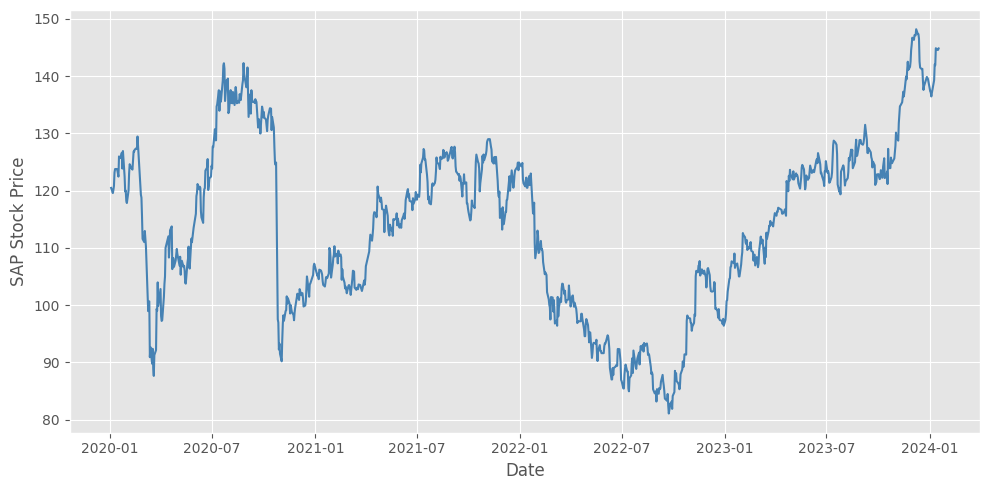

In [723]:
#plot - closing prices of sap
plt.figure(figsize=(10,5))
plt.plot(data_dict['SAP_DE']['Close'], color='steelblue', label = 'Stock Price')
plt.xlabel('Date')
plt.ylabel('SAP Stock Price')
#plt.legend()
plt.tight_layout()
#plt.savefig('sp_sap.png')

### 1.5. Asset Return Plots

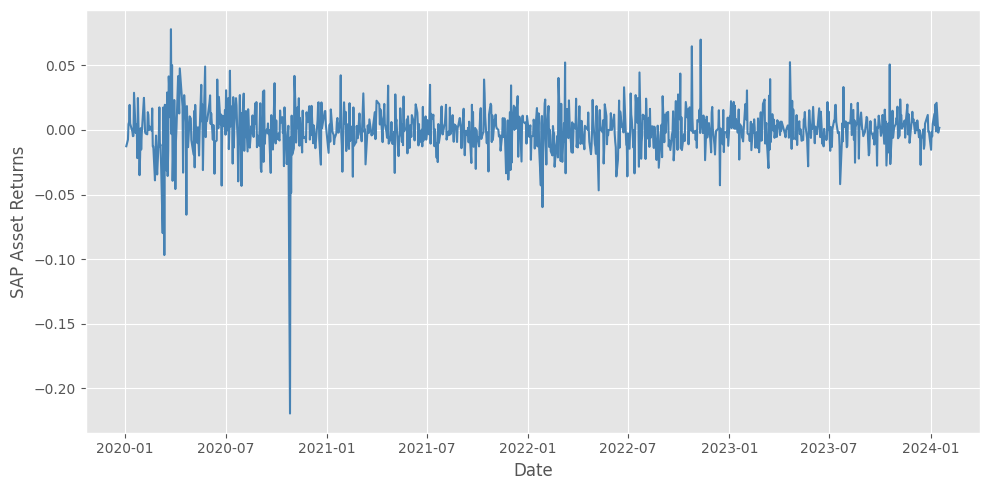

In [724]:
#plot - closing prices of sap
plt.figure(figsize=(10,5))
plt.plot(data_dict['SAP_DE']['1d_return'], color='steelblue', label = 'Asset Returns')
plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
#plt.legend()
plt.tight_layout()
#plt.savefig('sp_sap.png')

In [725]:
# Filter rows where '1d_return' is greater than 0.1 or less than -0.1
filtered_rows = data_dict['SAP_DE'].loc[(data_dict['SAP_DE']['1d_return'] > 0.1) | (data_dict['SAP_DE']['1d_return'] < -0.1)]

filtered_rows


,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
date,,,,,,,,,,,,,,,,,
2020-10-26,company:sap,DE0007164600,1625.0,3777.0,0.300888,6519.0,3.958668,5.234526,4.585975,4.15892,5.028906,3.676367,6.053406,4.780262,97.5,-0.219376,-0.255725


In [726]:
# # Initialize a list to hold the DataFrames
# subsequent_dfs = []

# # Iterate through the indices and get the next 10 rows for each
# for idx in indices:
#     # Find the integer location for the current index
#     int_location = data_dict['SAP_DE'].index.get_loc(idx)
    
#     # Check if the end location is beyond the length of the DataFrame
#     end_location = min(int_location + 11, len(data_dict['SAP_DE']))
    
#     # Get the next 10 rows from the current index using iloc
#     subsequent_rows = data_dict['SAP_DE'].iloc[int_location:end_location]
    
#     # Append the DataFrame to the list
#     subsequent_dfs.append(subsequent_rows)

# # Concatenate all the DataFrames in the list
# resulting_rows = pd.concat(subsequent_dfs).drop_duplicates()

# # Reset index of the resulting DataFrame (optional, for better readability)
# resulting_rows = resulting_rows.reset_index(drop=True)

# resulting_rows


In [727]:
#outliers of sap asset return series
count_outliers(data_dict['SAP_DE']['1d_return'])

Outliers in Asset Return Series:  46
Outliers exceeding Upper Bound in Asset Return Series:  21
Outliers falling below Lower Bound in Asset Return Series:  25


In [728]:
q1, q3 = np.percentile(data_dict['SAP_DE']['1d_return'], [25, 75])
q1, q3


(-0.007832020254103199, 0.00933054081455325)

### 1.6. Asset Return Histograms

In [729]:
#hyperparameter for histogram plots
bins = 50

/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_44961/1058912725.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_dict['SAP_DE']['1d_return'], hist = True, kde = False, bins = bins, label = 'histogram', norm_hist = True)
/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_44961/1058912725.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see


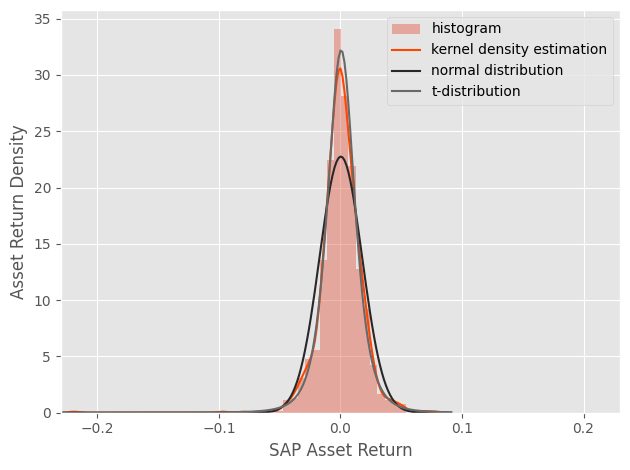

In [730]:
#histogram - closing prices of sap
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = True, kde = False, bins = bins, label = 'histogram', norm_hist = True)
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = False, kde = True, color= 'orangered', label = 'kernel density estimation')
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = False, kde = False, fit = stats.norm, label = 'normal distribution')
sns.distplot(data_dict['SAP_DE']['1d_return'], fit_kws={"color":"dimgrey"}, hist = False, kde = False, fit = stats.t, color = 'black', label = 't-distribution')
plt.xlabel('SAP Asset Return')
plt.ylabel('Asset Return Density')
plt.xlim(-0.23, 0.23)
plt.legend()
plt.tight_layout()
#plt.savefig('hist_ar_sap.png')

In [731]:
#basic figures about sap asset returns
print('Mean of SAP (Asset Return Series):',round((data_dict['SAP_DE']['1d_return']).mean(),6))
print('Standard Deviation of SAP (Asset Return Series):',round((data_dict['SAP_DE']['1d_return']).std(),6))
print('Average Daily Fluctuation of SAP (Asset Return Series):',round((abs(data_dict['SAP_DE']['1d_return'])).mean(),6))

Mean of SAP (Asset Return Series): 0.000325
Standard Deviation of SAP (Asset Return Series): 0.017545
Average Daily Fluctuation of SAP (Asset Return Series): 0.011828


### 1.7. Autocorrelation Plots

In [732]:
#hyperparameter for acf & pacf plots
lags = 12

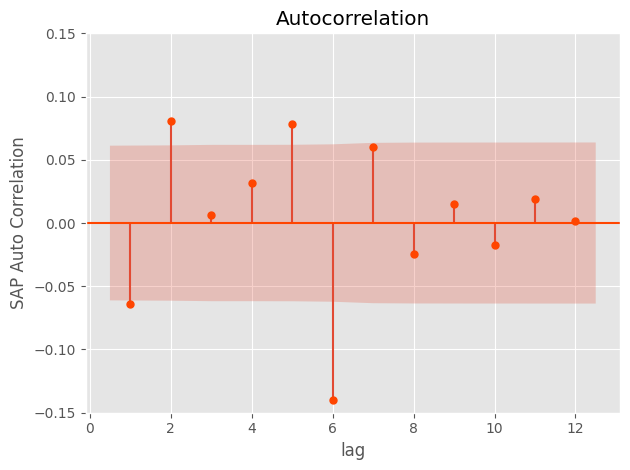

In [733]:
#autocorrelation plot - asset return of dax
plot_acf(data_dict['SAP_DE']['1d_return'], alpha=0.05, lags=lags, zero = False, color = 'orangered')
plt.xlabel('lag')
plt.ylabel('SAP Auto Correlation')
plt.ylim(-0.15, 0.15)
plt.tight_layout()
#plt.savefig('acf_ar_dax.png')

### 1.8. Partial Autocorrelation Plots

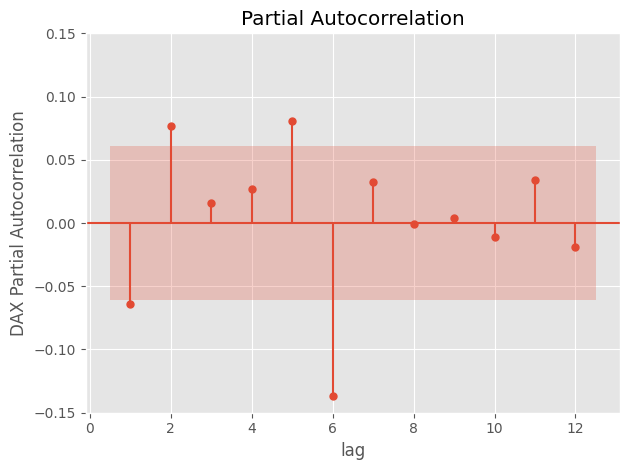

In [734]:
#partial autocorrelation plot - asset return of dax
plot_pacf(data_dict['SAP_DE']['1d_return'], alpha=0.05, lags=lags, zero = False)
plt.xlabel('lag')
plt.ylabel('DAX Partial Autocorrelation')
plt.ylim(-0.15, 0.15)
plt.tight_layout()
#plt.savefig('pacf_ar_dax.png')

### 1.9. Testing Stationarity

In [735]:
#Test for stationarity - dax
test_stationarity(data_dict['SAP_DE']['1d_return'])

Results of dickey fuller test:
Test Statistic                -1.333666e+01
p-value                        6.033352e-25
Number of lags used            5.000000e+00
Number of observations used    1.021000e+03
critical value (1%)           -3.436771e+00
critical value (5%)           -2.864375e+00
critical value (10%)          -2.568279e+00
dtype: float64


In [736]:
#Test for stationarity - dax
test_stationarity(data_dict['SAP_DE']['Close'])

Results of dickey fuller test:
Test Statistic                   -1.760745
p-value                           0.400117
Number of lags used               6.000000
Number of observations used    1020.000000
critical value (1%)              -3.436777
critical value (5%)              -2.864378
critical value (10%)             -2.568281
dtype: float64


### 1.10. Train/Test Splits for ARIMA & Determining Best ARIMA models

In [737]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 2
window = 10

In [738]:
#hyperparameter for train/test split
train_test_ratio = 7/10

In [739]:
#split sap asset returns into train and test set
train_arima_SAP, test_arima_SAP = train_test_split(data_dict['SAP_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3635.671, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3636.696, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3636.272, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3638.508, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3636.710, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3637.036, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3636.571, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3634.744, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3636.538, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.511 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  718
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1822.254
Date:                Sat, 17 Feb 2024   

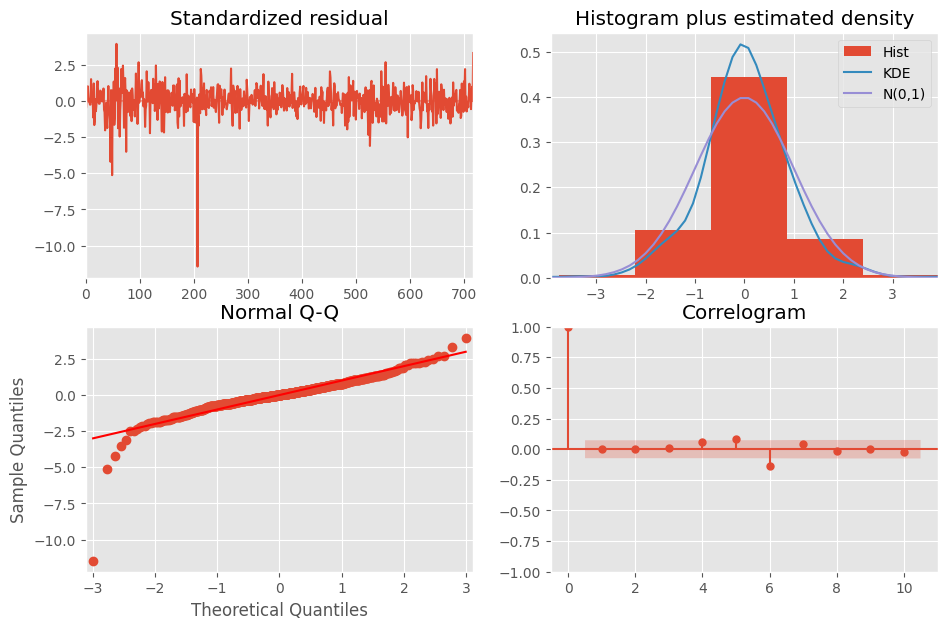

In [740]:
#determining most suitable arima order for dax prediction
autoarima_SAP = auto_arima(train_arima_SAP, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_SAP.summary())
autoarima_SAP.plot_diagnostics(figsize=(11,7))
plt.show()

In [741]:
#split dax asset returns into train and test set
train_arima_SIE, test_arima_SIE = train_test_split(data_dict['SIE_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3450.390, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3448.932, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3448.917, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3446.868, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3448.423, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.217 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  718
Model:                        SARIMAX   Log Likelihood                1726.195
Date:                Sat, 17 Feb 2024   AIC                          -3450.390
Time:                        16:33:41   BIC                          -3445.813
Sample:                             0   HQIC                         -3448.623
                                - 718                                  

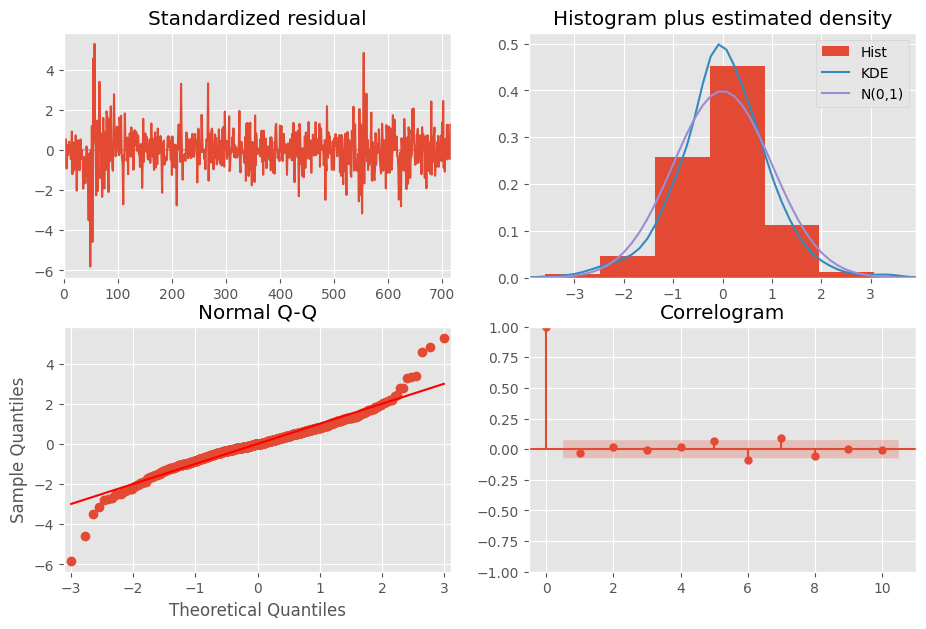

In [742]:
#determining most suitable arima order for sie prediction
autoarima_SIE = auto_arima(train_arima_SIE, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_SIE.summary())
autoarima_SIE.plot_diagnostics(figsize=(11,7))
plt.show()

In [743]:
#split dax asset returns into train and test set
train_arima_DTE, test_arima_DTE = train_test_split(data_dict['DTE_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3947.287, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3948.811, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3948.265, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3952.003, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3954.815, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3952.857, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3944.821, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-3953.327, Time=0.06 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.583 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  718
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1981.407
Date:                Sat, 17 Feb 2024   AIC                          -3954.815
Time:                       

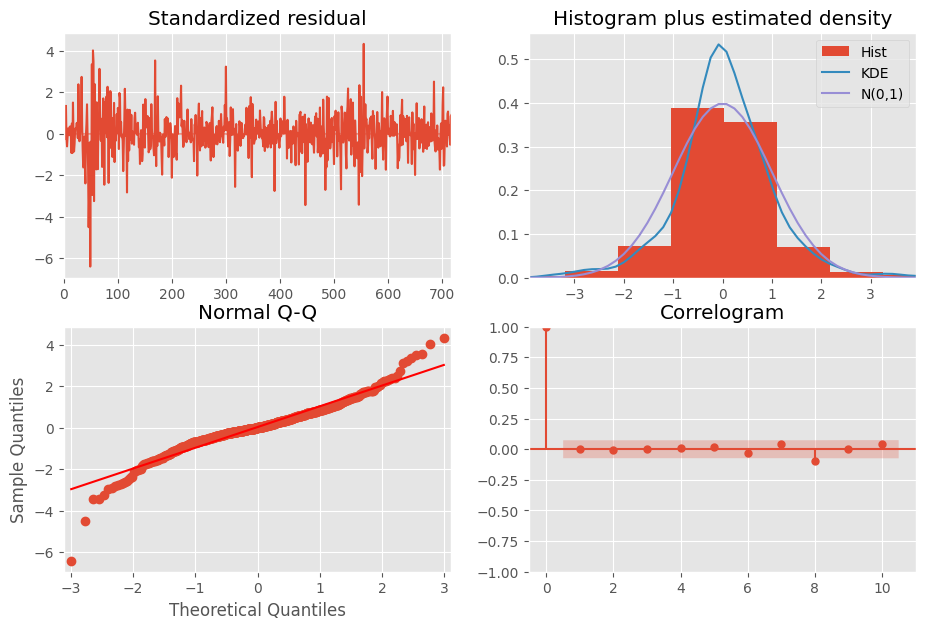

In [744]:
#determining most suitable arima order for sie prediction
autoarima_DTE = auto_arima(train_arima_DTE, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima_DTE.summary())
autoarima_DTE.plot_diagnostics(figsize=(11,7))
plt.show()

### 1.11. Feature Engineering

In [745]:
#feature engineering for other top 3 german components in eurostoxx50 prediction
rolmean_SAP = data_dict['SAP_DE']['1d_return'].rolling(window).mean()
rolstd_SAP = data_dict['SAP_DE']['1d_return'].rolling(window).std()

rolmean_SIE = data_dict['SIE_DE']['1d_return'].rolling(window).mean()
rolstd_SIE = data_dict['SIE_DE']['1d_return'].rolling(window).std()

rolmean_DTE = data_dict['DTE_DE']['1d_return'].rolling(window).mean()
rolstd_DTE = data_dict['DTE_DE']['1d_return'].rolling(window).std()

#adding features as columns in dataframe for dax
data_dict['SAP_DE']['Rolling_Mean'] = rolmean_SAP
data_dict['SAP_DE']['Rolling_Std'] = rolstd_SAP

data_dict['SIE_DE']['Rolling_Mean'] = rolmean_SIE
data_dict['SIE_DE']['Rolling_Std'] = rolstd_SIE

#adding features as columns in dataframe for dax
data_dict['DTE_DE']['Rolling_Mean'] = rolmean_DTE
data_dict['DTE_DE']['Rolling_Std'] = rolstd_DTE

In [746]:
data_dict['SAP_DE']['1d_return']

date
2020-01-03   -0.012623
2020-01-06   -0.007471
2020-01-07    0.004517
2020-01-08    0.005995
2020-01-09    0.019368
                ...   
2024-01-11   -0.001126
2024-01-12    0.021004
2024-01-15   -0.002071
2024-01-16    0.000138
2024-01-17    0.001660
Name: 1d_return, Length: 1027, dtype: float64

In [747]:
data_dict['SAP_DE'][['Rolling_Mean']]

,Rolling_Mean
date,
2020-01-03,NaN
2020-01-06,NaN
2020-01-07,NaN
2020-01-08,NaN
2020-01-09,NaN
...,...
2024-01-11,0.001491
2024-01-12,0.003734
2024-01-15,0.003641


In [748]:
data_dict['SAP_DE']['Rolling_Mean'][window-1:]

date
2020-01-16    0.000396
2020-01-17    0.004533
2020-01-20    0.005042
2020-01-21    0.005020
2020-01-22    0.004737
                ...   
2024-01-11    0.001491
2024-01-12    0.003734
2024-01-15    0.003641
2024-01-16    0.005189
2024-01-17    0.005516
Name: Rolling_Mean, Length: 1018, dtype: float64

In [749]:
#disregarding rows for which feature values can not be generated - top 3 german components
data_dict['SAP_DE'] = data_dict['SAP_DE'][window-1:]

data_dict['SIE_DE'] = data_dict['SIE_DE'][window-1:]

data_dict['DTE_DE'] = data_dict['DTE_DE'][window-1:]

#do this for all if needed later

In [750]:
data_dict['SAP_DE']

,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling_Mean,Rolling_Std
date,,,,,,,,,,,,,,,,,,,
2020-01-16,company:sap,DE0007164600,500.000000,56.000000,0.897849,1175.000000,3.969499,5.115419,5.680735,4.179644,5.497494,4.566708,0.000000,3.720626,122.440002,-0.004553,-0.005846,0.000396,0.008912
2020-01-17,company:sap,DE0007164600,238.666667,21.333333,0.876859,475.666667,3.962576,5.136020,5.643958,4.188857,5.465654,4.545760,0.000000,3.799935,125.959999,0.028749,0.017776,0.004533,0.011441
2020-01-20,company:sap,DE0007164600,416.000000,37.000000,0.916484,770.000000,3.888357,5.170561,5.649165,4.148302,5.607866,4.691917,6.182072,4.038308,125.660004,-0.002382,0.015352,0.005042,0.010950
2020-01-21,company:sap,DE0007164600,652.000000,51.000000,0.926241,1225.000000,3.875312,5.201468,5.654158,4.137257,5.545911,4.623552,6.163872,4.155238,126.199997,0.004297,0.021036,0.005020,0.010951
2020-01-22,company:sap,DE0007164600,720.000000,57.000000,0.925546,1188.000000,3.926014,5.348326,5.625235,4.184493,5.291100,4.375904,5.970151,4.042344,126.599998,0.003170,0.029268,0.004737,0.010960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,-0.001126,0.039871,0.001491,0.009583
2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,0.021004,0.056755,0.003734,0.011296
2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,-0.002071,0.041649,0.003641,0.011344


### 1.12. Splitting Sequences & Generating Train/Test Sets for LSTM prediction

In [751]:
#general hyperparameter
input_steps = 20
output_steps = 1 #one day ahead prediction

In [752]:
#creating two sequence out of which one predicts the other - asset return of dax
X_SAP,Y_SAP = split_sequence(data_dict['SAP_DE']['1d_return'], input_steps, output_steps)

#creating two sequence out of which one predicts the other - features of SAP
X1_SAP,Y1_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Mean'], input_steps, output_steps)

X2_SAP,Y2_SAP = split_sequence(data_dict['SAP_DE']['Rolling_Std'], input_steps, output_steps)

#concatenating input variables for lstm
X_ft_SAP = np.concatenate([X_SAP,X1_SAP,X2_SAP])

#reshaping
#X_SAP = np.reshape(X_SAP, (X_SAP.shape[0], input_steps, 1), order='F')
X_ft_SAP = np.reshape(X_ft_SAP, (int(X_ft_SAP.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
Y_SAP = np.reshape(Y_SAP, (Y_SAP.shape[0], output_steps), order='F')

#bringing Y in array form
Y_SAP = [i[output_steps - 1] for i in Y_SAP.tolist()]
Y_SAP = np.array(Y_SAP)

#splitting sequence into train, val and test data (70-15-15 split)
# First split: Separate out the test set
X_temp, X_ft_test_SAP, Y_temp, Y_test_SAP = train_test_split(X_ft_SAP, Y_SAP, test_size=0.15, shuffle=False)
# Second split: Split the remaining data into training and validation sets
X_ft_train_SAP, X_ft_val_SAP, Y_train_SAP, Y_val_SAP = train_test_split(X_temp, Y_temp, test_size=0.1765, shuffle=False)  # 0.25 * 0.8 = 0.2 # 0.1765 * 0.85 = 0.15

In [753]:
# #creating two sequence out of which one predicts the other - asset return of SIE
# X_SIE,Y_SIE = split_sequence(data_dict['SIE_DE']['1d_return'], input_steps, output_steps)

# #creating two sequence out of which one predicts the other - features of SIE
# X1_SIE,Y1_SIE = split_sequence(data_dict['SIE_DE']['Rolling_Mean'], input_steps, output_steps)

# X2_SIE,Y2_SIE = split_sequence(data_dict['SIE_DE']['Rolling_Std'], input_steps, output_steps)

# #concatenating input variables for lstm
# X_ft_SIE = np.concatenate([X_SIE,X1_SIE,X2_SIE])

# #reshaping
# #X_SIE = np.reshape(X_SIE, (X_SIE.shape[0], input_steps, 1), order='F')
# X_ft_SIE = np.reshape(X_ft_SIE, (int(X_ft_SIE.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
# Y_SIE = np.reshape(Y_SIE, (Y_SIE.shape[0], output_steps), order='F')

# #bringing Y in array form
# Y_SIE = [i[output_steps - 1] for i in Y_SIE.tolist()]
# Y_SIE = np.array(Y_SIE)

# #splitting sequence into train and test data
# #X_train_SIE, X_test_SIE, Y_train_SIE, Y_test_SIE = train_test_split(X_ft_SAP, Y_SAP, test_size=1-train_test_ratio, shuffle = False) #without features
# X_ft_train_SIE, X_ft_test_SIE, Y_train_SIE, Y_test_SIE = train_test_split(X_ft_SIE, Y_SIE, test_size=1-train_test_ratio, shuffle = False) #with features

In [754]:
# #creating two sequence out of which one predicts the other - asset return of dax
# X_DTE,Y_DTE = split_sequence(data_dict['DTE_DE']['1d_return'], input_steps, output_steps)

# #creating two sequence out of which one predicts the other - features of DTE
# X1_DTE,Y1_DTE = split_sequence(data_dict['DTE_DE']['Rolling_Mean'], input_steps, output_steps)

# X2_DTE,Y2_DTE = split_sequence(data_dict['DTE_DE']['Rolling_Std'], input_steps, output_steps)

# #concatenating input variables for lstm
# X_ft_DTE = np.concatenate([X_DTE,X1_DTE,X2_DTE])

# #reshaping
# #X_DTE = np.reshape(X_DTE, (X_DTE.shape[0], input_steps, 1), order='F')
# X_ft_DTE = np.reshape(X_ft_DTE, (int(X_ft_DTE.shape[0]/(n_features+1)), input_steps, n_features + 1), order='F')
# Y_DTE = np.reshape(Y_DTE, (Y_DTE.shape[0], output_steps), order='F')

# #bringing Y in array form
# Y_DTE = [i[output_steps - 1] for i in Y_DTE.tolist()]
# Y_DTE = np.array(Y_DTE)

# #splitting sequence into train and test data
# #X_train_DTE, X_test_DTE, Y_train_DTE, Y_test_DTE = train_test_split(X_ft_DTE, Y_DTE, test_size=1-train_test_ratio, shuffle = False) #without features
# X_ft_train_DTE, X_ft_test_DTE, Y_train_DTE, Y_test_DTE = train_test_split(X_ft_DTE, Y_DTE, test_size=1-train_test_ratio, shuffle = False) #with features

## 2. One day ahead prediction

### 2.1 LSTM Model & Prediction

In [755]:
#hyperparameter for lstm
epochs = 20
verbose = 1

In [756]:
#need to set seeds again in this part of the code for lstm to get the same outputs
seed = 2
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#LSTM model for dax asset return prediction
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(20, activation='sigmoid', return_sequences=False, input_shape=(input_steps, n_features + 1)))
model_LSTM.add(tf.keras.layers.Dense(1))
model_LSTM.compile(optimizer='Adam', loss='mse')

#training model 
history_LSTM_SAP = model_LSTM.fit(X_ft_train_SAP, Y_train_SAP, epochs = epochs, verbose = verbose, validation_data=(X_ft_val_SAP, Y_val_SAP))

#predicting values for SAP asset returns
yhat_SAP=model_LSTM.predict(X_ft_test_SAP)

Epoch 1/20
22/22 [==============================] - 1s 9ms/step - loss: 0.0157 - val_loss: 0.0041
Epoch 2/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 5.1696e-04
Epoch 3/20
22/22 [==============================] - 0s 2ms/step - loss: 5.0914e-04 - val_loss: 2.7505e-04
Epoch 4/20
22/22 [==============================] - 0s 3ms/step - loss: 3.9388e-04 - val_loss: 1.8570e-04
Epoch 5/20
22/22 [==============================] - 0s 2ms/step - loss: 3.7235e-04 - val_loss: 1.9063e-04
Epoch 6/20
22/22 [==============================] - 0s 2ms/step - loss: 3.7513e-04 - val_loss: 1.8472e-04
Epoch 7/20
22/22 [==============================] - 0s 2ms/step - loss: 3.7488e-04 - val_loss: 1.8480e-04
Epoch 8/20
22/22 [==============================] - 0s 3ms/step - loss: 3.7259e-04 - val_loss: 1.8576e-04
Epoch 9/20
22/22 [==============================] - 0s 2ms/step - loss: 3.8358e-04 - val_loss: 1.9140e-04
Epoch 10/20
22/22 [==============================] - 0s 2m

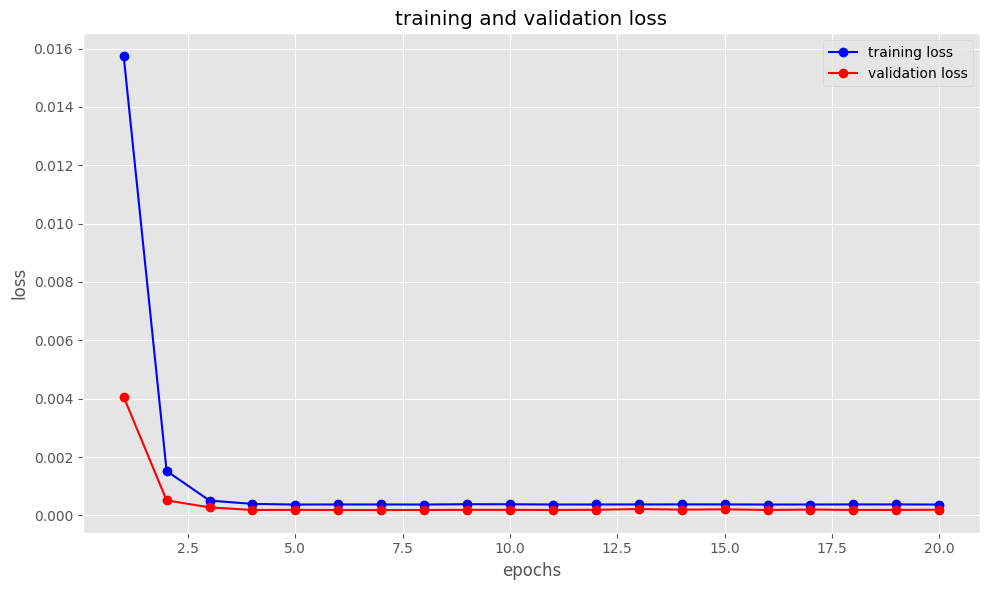

In [765]:
#plot - loss of lstm sap prediction
train_loss = history_LSTM_SAP.history['loss']
val_loss = history_LSTM_SAP.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='training loss')
plt.plot(epochs, val_loss, 'ro-', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()


In [705]:
#bringing yhat in flat form
#yhat_reshape_SAP = yhat_SAP.reshape(-1,1).reshape(-1,1)
yhat_flat_SAP = [item for sublist in yhat_SAP.tolist() for item in sublist]

#review performance of sap lstm
mse_LSTM = mean_squared_error(yhat_flat_SAP, Y_test_SAP)
print('MSE_LSTM: '+str("{:e}".format(mse_LSTM)))
mae_LSTM = mean_absolute_error(yhat_flat_SAP, Y_test_SAP)
print('MAE_LSTM: '+str("{:e}".format(mae_LSTM)))
rmse_LSTM = math.sqrt(mean_squared_error(yhat_flat_SAP, Y_test_SAP))
print('RMSE_LSTM: '+str("{:e}".format(rmse_LSTM)))

MSE_LSTM: 1.690077e-04
MAE_LSTM: 9.173726e-03
RMSE_LSTM: 1.300030e-02


In [401]:
model_LSTM.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 20)                1920      
                                                                 
 dense_21 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1941 (7.58 KB)
Trainable params: 1941 (7.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2.2 ARIMA Model & Prediction

In [402]:
#arima model for sap asset return prediction
model_arima_SAP = ARIMA(train_arima_SAP, order=autoarima_SAP.order)  
fitted_SAP = model_arima_SAP.fit()  
print(fitted_SAP.summary())

                               SARIMAX Results                                
Dep. Variable:              1d_return   No. Observations:                  718
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1822.269
Date:                Sat, 17 Feb 2024   AIC                          -3636.538
Time:                        13:15:59   BIC                          -3618.232
Sample:                             0   HQIC                         -3629.470
                                - 718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.158      0.875      -0.002       0.001
ar.L1         -0.0611      0.041     -1.499      0.134      -0.141       0.019
ar.L2          0.0734      0.031      2.374      0.0

/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [403]:
#arima prediction for sap returns
history_arima_SAP = [x for x in train_arima_SAP]
predictions_arima_SAP = list()
for t in range(len(test_arima_SAP)):
    model_arima_SAP = ARIMA(history_arima_SAP, order=autoarima_SAP.order)
    model_fit_arima_SAP = model_arima_SAP.fit()
    output_arima_SAP = model_fit_arima_SAP.forecast(steps = output_steps)
    #yhat_arima_SAP = output_arima_SAP[0].tolist()[output_steps - 1]
    predictions_arima_SAP.append(output_arima_SAP)
    obs_SAP = test_arima_SAP[t]
    history_arima_SAP.append(obs_SAP)

#bringing arima predictions in flat form
predicted_arima_flat_SAP = [float(i) for i in predictions_arima_SAP]

#review performance
mse_arima_SAP = mean_squared_error(test_arima_SAP, predicted_arima_flat_SAP)
print('MSE_ARIMA_SAP: '+str("{:e}".format(mse_arima_SAP)))
mae_arima_SAP = mean_absolute_error(test_arima_SAP, predicted_arima_flat_SAP)
print('MAE_ARIMA_SAP: '+str("{:e}".format(mae_arima_SAP)))
rmse_arima_SAP = math.sqrt(mean_squared_error(test_arima_SAP, predicted_arima_flat_SAP))
print('RMSE_ARIMA_SAP: '+str("{:e}".format(rmse_arima_SAP)))   

/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_44961/906134491.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs_SAP = test_arima_SAP[t]


/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

MSE_ARIMA_SAP: 1.626852e-04
MAE_ARIMA_SAP: 9.104465e-03
RMSE_ARIMA_SAP: 1.275481e-02


/Users/cemakkus/PycharmProjects/Master/masterenv_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_44961/906134491.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_arima_flat_SAP = [float(i) for i in predictions_arima_SAP]


### 2.3 Comparison between LSTM & ARIMA Predictions - SAP

In [404]:
#adding back index to the dax predictions and actual values
min_comp = min(yhat_reshape_SAP.shape[0],len(predictions_arima_SAP))

pred_lstm = pd.Series(yhat_flat_SAP[-min_comp:],index=data_dict['SAP_DE']['1d_return'].iloc[-min_comp:].index)
actual = pd.Series(Y_test_SAP[-min_comp:],index=data_dict['SAP_DE']['1d_return'].iloc[-min_comp:].index)
pred_arima = pd.Series(predicted_arima_flat_SAP[-min_comp:],index=data_dict['SAP_DE']['1d_return'].iloc[-min_comp:].index)

predictions_SAP = pd.concat([actual,pred_lstm, pred_arima], axis=1, keys=['actual','pred_lstm','pred_arima'])

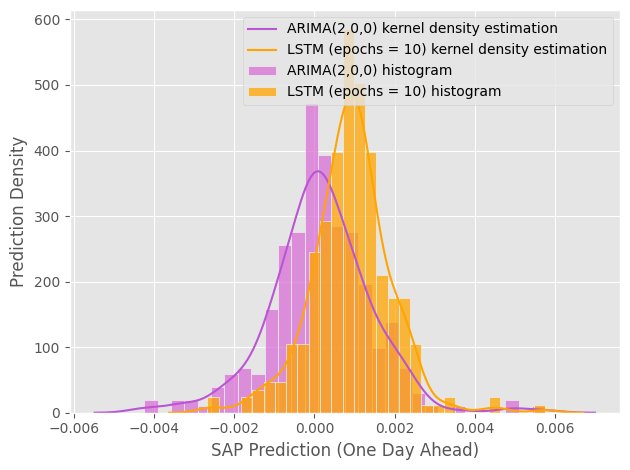

In [405]:
# Setting up the bins parameter for consistency across histograms
bins = 30  # Adjust the number of bins as needed

# ARIMA Histogram
sns.histplot(data=predictions_SAP, x='pred_arima', bins=bins, color='orchid', stat='density', label='ARIMA(2,0,0) histogram')

# ARIMA KDE
sns.kdeplot(data=predictions_SAP, x='pred_arima', color='mediumorchid', label='ARIMA(2,0,0) kernel density estimation')

# LSTM Histogram
sns.histplot(data=predictions_SAP, x='pred_lstm', bins=bins, color='orange', stat='density', label='LSTM (epochs = 10) histogram')

# LSTM KDE
sns.kdeplot(data=predictions_SAP, x='pred_lstm', color='orange', label='LSTM (epochs = 10) kernel density estimation')

# Actual Histogram
#sns.histplot(data=predictions_SAP, x='actual', bins=bins, color='blue', stat='density', label='Actual histogram')

# Actual KDE
#sns.kdeplot(data=predictions_SAP, x='actual', color='blue', label='Actual kernel density estimation')

# Adding labels and adjusting layout
plt.xlabel('SAP Prediction (One Day Ahead)')
plt.ylabel('Prediction Density')
plt.tight_layout()
plt.legend()

# Uncomment the following line if you want to save the figure
#plt.savefig('hist_pred_sap.png')

plt.show()


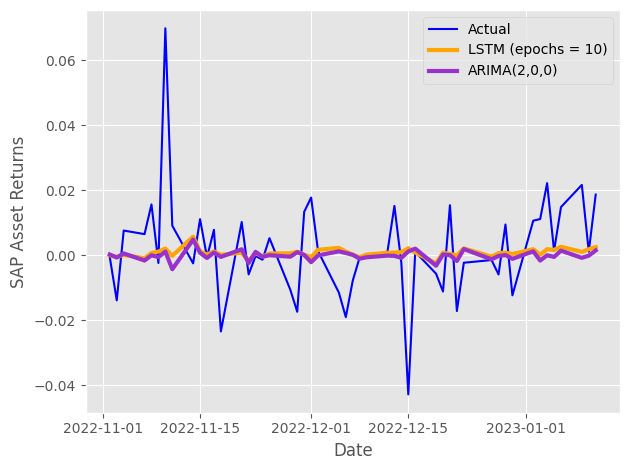

In [406]:
#plot - sap asset return predictions
plt.plot(predictions_SAP['actual'][0:50], color= 'blue', label = 'Actual')
plt.plot(predictions_SAP['pred_lstm'][0:50], color= 'orange', label = 'LSTM (epochs = 10)', linewidth = 3)
plt.plot(predictions_SAP['pred_arima'][0:50], color= 'darkorchid', label = 'ARIMA(2,0,0)', linewidth = 3)
plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
plt.legend()
plt.tight_layout()
#plt.savefig('pred_sap_5.png')

In [407]:
#adding columns indicating if values are positive or negative
actual_sign = []
for i in predictions_SAP['actual']:
    if i >= 0:
        actual_sign.append('Pos')
    else:
        actual_sign.append('Neg')
        
predictions_SAP['actual_sign'] = actual_sign  

pred_arima_sign = []
for i in predictions_SAP['pred_arima']:
    if i >= 0:
        pred_arima_sign.append('Pos')
    else:
        pred_arima_sign.append('Neg')
        
predictions_SAP['pred_arima_sign'] = pred_arima_sign

pred_lstm_sign = []
for i in predictions_SAP['pred_lstm']:
    if i >= 0:
        pred_lstm_sign.append('Pos')
    else:
        pred_lstm_sign.append('Neg')
        
predictions_SAP['pred_lstm_sign'] = pred_lstm_sign

In [408]:
#arima dax prediction confusion matrix
tp_arima = 0
fp_arima = 0 
tn_arima = 0 
fn_arima = 0 
for i, j in zip(predictions_SAP['actual_sign'], predictions_SAP['pred_arima_sign']):   
        if i == 'Pos' and j == 'Pos':
            tp_arima += 1
        elif i == 'Pos' and j == 'Neg':
            fn_arima += 1
        elif i == 'Neg' and j == 'Neg':
            tn_arima += 1
        else:
            fp_arima += 1
        
print('True Positive for SAP ARIMA prediction: ', tp_arima) 
print('False Positive for SAP ARIMA prediction: ', fp_arima) 
print('True Negative for SAP ARIMA prediction: ', tn_arima) 
print('False Negative for SAP ARIMA prediction: ', fn_arima)
print('Up/Down Accuracy of ARIMA prediction: ', round((tp_arima + tn_arima) / (tp_arima + fp_arima + tn_arima + fn_arima),4))

#lstm dax prediction confusion matrix
tp_lstm = 0
fp_lstm = 0 
tn_lstm = 0 
fn_lstm = 0 
for i, j in zip(predictions_SAP['actual_sign'], predictions_SAP['pred_lstm_sign']):   
        if i == 'Pos' and j == 'Pos':
            tp_lstm += 1
        elif i == 'Pos' and j == 'Neg':
            fn_lstm += 1
        elif i == 'Neg' and j == 'Neg':
            tn_lstm += 1
        else:
            fp_lstm += 1
        
print('True Positive for SAP LSTM prediction: ', tp_lstm) 
print('False Positive for SAP LSTM prediction: ', fp_lstm) 
print('True Negative for SAP LSTM prediction: ', tn_lstm) 
print('False Negative for SAP LSTM prediction: ', fn_lstm) 
print('Up/Down Accuracy of SAP LSTM prediction: ', round((tp_lstm + tn_lstm) / (tp_lstm + fp_lstm + tn_lstm + fn_lstm),4))

True Positive for SAP ARIMA prediction:  92
False Positive for SAP ARIMA prediction:  74
True Negative for SAP ARIMA prediction:  65
False Negative for SAP ARIMA prediction:  73
Up/Down Accuracy of ARIMA prediction:  0.5164
True Positive for SAP LSTM prediction:  145
False Positive for SAP LSTM prediction:  117
True Negative for SAP LSTM prediction:  22
False Negative for SAP LSTM prediction:  20
Up/Down Accuracy of SAP LSTM prediction:  0.5493


### 2.4. 